In [4]:
# ------- Styling ------- 
#%matplotlib ipympl
#For interactive plots
%matplotlib inline
#For inline plots

# SNSolver

## Introduction
This is a Jupyter notebook for the purpose of testing and devloping a differential equation solver for the Schordinger-Newton (SN) equation which is non-linear in nature. Hence, analytical solutions are often complicated if one exists at all.

## Theory
The SN equation is given by an potential additional term to the Hamiltonian ($\hat H$) to include the self gravity potentials which is semiclassical in nature such that it reads:
$$\bigg[-\frac{\hbar^2}{2m} \nabla^2+ V(x) + m\Phi(x)\bigg]\psi= i\hbar \dfrac{d\Psi}{dt} 
$$
where also $\nabla^2 \Phi = 4\pi G\rho$ which is a Poisson equation coming the divergence of Gauss's law for gravity:
$$\nabla \cdot (\bf{g})= -4 \pi G \rho $$
for some mass density $\rho$
Then recalling the relationship between a vector field $\bf g$ and its scalar potential $\Phi$:
$$\nabla \cdot (\bf{g})  = -4\pi G \rho$$
$$\nabla \cdot (-\nabla \Phi) = - 4\pi G\rho$$
$$\nabla^2 \Phi = 4\pi G \rho$$
However, in a quatum system, the mass density is directly proportional to the probability density $|\psi|^2$, and so:
$$\nabla^2 \Phi = 4\pi G m|\psi|^2$$
> Hence, we see our Schrodinger-Newton equation is a nonlinear 2nd order PDE on $\Psi$

Going forward, we then have two key equations:
$$\bigg[-\frac{\hbar^2}{2m} \nabla^2+ V(x) + m\Phi(x)\bigg]\psi= i\hbar \dfrac{d\Psi}{dt},
\quad 
\nabla^2 \Phi = 4\pi G m|\psi|^2$$

# Physics-Informed Neural Network
The solution for the SN equation from the **Theory** section is often highly complicated to solve analytically, dependent on our initial wavefunction. Therefore, a numerical solution should be considered.

## Create Environment 
The required libraries are included from the environment yaml file `pinn_env.yml`. To install, simply do:
```bash
conda env create -n pinn_env -f [where your environemnt yaml file is]
conda activate pinn_env
```
## Importing Necessary Libraries
In the next cell, we import necessary libraries for our codes:

In [26]:
# ------- Importing Libraries ------- 
from PIL import Image #For our image saving/writing (https://pillow.readthedocs.io/en/stable/reference/Image.html)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import scipy.optimize

## Fully Connected Network
Here we define a Fully Connect Networks (FCN) and some helpful functions for our PINN and we are training the PINN to solve for $\Psi = \Re\{\psi\}+i \Im\{\psi\}$, as our wavefunctions are generally complex, and we demand it to satisfy the SN equation. 

In [6]:
# ------- Fully Connected Network ------- 
class FCN(nn.Module):
    """Fully Connected Network for complex-valued wavefunction ψ = Re + i·Im."""
    
    def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # activation function
        
        # input layer
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        
        # hidden layers
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS - 1)
        ])
        
        # output layer: 2 outputs (Re(ψ), Im(ψ))
        self.fce = nn.Linear(N_HIDDEN, 2)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        # Split output into real and imaginary parts
        psi_re = x[:, 0:1]
        psi_im = x[:, 1:2]
        
        return psi_re, psi_im

# ------- GIF Saving Function ------- 
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# ------- Dervatives calculation ------- 
def derivatives(u, xt):
    grads = torch.autograd.grad(
        u, xt,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]  # grads is (N, 2)
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]

    u_xx = torch.autograd.grad(
        u_x, xt,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0][:, 0:1]

    return u_t, u_xx


# PINN Driven Training 
The neurons will go through a training loop via the FCN and tries to minise the loss function $\mathcal L$ for some input grid (user defined). Then it will provide an output (i.e. numerical solution) after N numbers of epochs.

## Define Setupt Parameters
Let's define our parameters as follows:

In [7]:
#Define Physical Constants 
hbar = 1
G = 1
m = 1

#Define Learning Regions 
x_min, x_max = -3,3 #Learning over space region of [x_min, x_max]
t_min, t_max = 0, 2 #Learing over time of [t_min, t_max]
nx = 100 #No. of learning points over space region 
nt = 100 #No. of learning points over time region

# Weighting for each loss function
lambda_SN = 1 #from SN equation
lambda_PEq = 1 #from Poisson Equation
lambda_IC = 1 #from Initial Condition 


## Define Input Grid
We input create a mesh grid of arrays populated with learning points for position x and time t, bundled into their respective tensors `X` an `T`, or collectively as a single tensor object `xt`

In [8]:
#Setup our learning input tensors

x_train = torch.linspace(x_min, x_max, nx).view(-1, 1)
t_train = torch.linspace(t_min, t_max, nt).view(-1, 1)
X, T = torch.meshgrid(x_train.squeeze(), t_train.squeeze(), indexing='ij')

xt = torch.cat((X.reshape(-1,1), T.reshape(-1,1)), dim=1) #Combining X and T into a single tensors
xt.requires_grad_(True); #The semicolon avoids printing xt and clustering the screen!
#Note: x is xt[:,0] and t is xt[:,1]

## Training Neurons
Now that we have an input grid, we want to put it through a training loop over the FCN where the input via an optimser (we use Adam) goes through:
1) activation function of choice (we choose $\tanh()$)
2) minisation of the loss function
3) plot results every set interval
4) repeat for N epochs

### Models and Optimiser
Now we define our models for $\psi(x,t)$ and $\phi(x,t)$, as well as, the optimiser.

In [9]:
def initialise():
    # Seed
    torch.manual_seed(123)

    # Define models
    psi_model = FCN(N_INPUT=2, N_HIDDEN=32, N_LAYERS=3)
    phi_model = FCN(N_INPUT=2, N_HIDDEN=32, N_LAYERS=3)

    # Define optimizer
    optimizer = torch.optim.Adam(
        list(psi_model.parameters()) + list(phi_model.parameters()),
        lr=1e-3
    )

    return psi_model, phi_model, optimizer

### PINN Loss Function
Even with a lack of experimental data, we can ask the PINN to brute force over a domain of inputs to get a numerical solution that satifies the SN equation by imbedding Physics knowledge inside the training process via the loss function. As stated previously, the PINN has to find conditions that minimise the loss function $\mathcal L$. 

Recall the following known Physics:
$$\bigg[-\frac{\hbar^2}{2m}\nabla^2+m\Phi\bigg]\psi = i\hbar \dfrac{d\psi}{dt}
\quad
\text{and}
\quad
\nabla^2 \Phi = 4\pi G m|\psi|^2 $$
Since we demand our wavefunction to also be normalised, then:
$$\int_{\mathbb R^3} |\psi|^2 d^3 r = 1$$
However, this condition can also this can be potentially computing heavy and is prone to error as a loss function.

Finally, if we can definite some initial state $\psi_0(x)$, then we have the intial condition:
$$ \psi(x,0) = \psi_0(x)$$
for example, $\psi_0(x) = \bigg(\frac{a}{2\pi}\bigg)^{}$

Therefore, have 3 loss functions $\mathcal L$ formed as a residue as the above:
$$\mathcal L_1 = \lambda_{SN}\bigg[-\frac{\hbar^2}{2m}\nabla^2+m\Phi\bigg]\psi - i\hbar \dfrac{d\psi}{dt}\bigg]$$ 
$$\mathcal L_2 =  \lambda_{PEq}\bigg[\nabla^2 \Phi - 4\pi G m|\psi|^2 \bigg],
\quad
\mathcal L_3 = \lambda_{Norm}\bigg[\int_{\mathbb R^3} |\psi|^2 - 1 d^3 r \bigg]$$
$$\mathcal L_4 = \lambda_{IC} \bigg[\psi(\bf{r},0) = \psi_0(\bf{r})\bigg]$$
for some weights $\lambda_i$ and the total loss function is given by: $$\mathcal L_{tot} = \displaystyle \sum_i \lambda_i \mathcal L_i$$

### Define Loss Function
Let's then define our loss function in codes:

In [10]:
#Define Initial State psi_0 for psi(x,0):
def psi_0(xt):
    x = xt[:, 0:1]
    return (1 / torch.pi)**0.25 * torch.exp(-x**2 / 2)

# Defining Loss Function for input of some values of x and t:
def loss(xt):
    # Extract x and t
    x = xt[:, 0:1]
    t = xt[:, 1:2]

    # Forward pass through the models
    psi_re, psi_im = psi_model(xt)
    phi_re, _ = phi_model(xt)   # phi_im ignored (Poisson potential is real)

    # Compute derivatives
    psi_re_t, psi_re_xx = derivatives(psi_re, xt)
    psi_im_t, psi_im_xx = derivatives(psi_im, xt)
    _, phi_xx = derivatives(phi_re, xt)   # phi_t not needed

    # Schrödinger–Newton Residue for the real & imaginary components
    SN_re = hbar * psi_im_t + (hbar**2 / (2*m)) * psi_re_xx - m * phi_re * psi_re
    SN_im = -hbar * psi_re_t + (hbar**2 / (2*m)) * psi_im_xx - m * phi_re * psi_im

    # Probability density
    PD = psi_re**2 + psi_im**2

    # Poisson equation Residue
    PEq = phi_xx - 4 * np.pi * G * m * PD

    # Boundary / initial conditions
    # (you can add psi(x,0) = psi_0(x))
    xt0 = xt[t.squeeze() < 1e-6]  # Chossing values of x for t approximately equals t 0
    if len(xt0) > 0:
        psi0_re, psi0_im = psi_model(xt0)
        psi_init = psi0_re + 1j * psi0_im
        loss_IC = torch.mean(torch.abs(psi_init - psi_0(xt0))**2) 
    else:
        loss_IC = 0.0
    
    # Combine residuals
    loss_SN = torch.mean(SN_re**2 + SN_im**2)
    loss_PEq = torch.mean(PEq**2) 
    
    # Total weighted loss
    loss = (lambda_SN * loss_SN) + (lambda_PEq * loss_PEq) + (lambda_IC*loss_IC)
    return loss

### Training Loops
Now that we have coded the necessary ingreidents for the training loops, let's actually implement it into a training loop.

Training PINN:   0%|                       | 3/1001 [00:00<01:14, 13.45 epoch/s]

Epoch 0: Loss = 0.225630


Training PINN:  10%|██                   | 101/1001 [00:04<00:46, 19.19 epoch/s]

Epoch 100: Loss = 0.058735


Training PINN:  20%|████▎                | 203/1001 [00:09<00:42, 18.76 epoch/s]

Epoch 200: Loss = 0.030821


Training PINN:  30%|██████▎              | 302/1001 [00:13<00:39, 17.53 epoch/s]

Epoch 300: Loss = 0.022132


Training PINN:  40%|████████▍            | 403/1001 [00:18<00:32, 18.40 epoch/s]

Epoch 400: Loss = 0.018053


Training PINN:  50%|██████████▌          | 502/1001 [00:23<00:26, 18.65 epoch/s]

Epoch 500: Loss = 0.015584


Training PINN:  60%|████████████▌        | 601/1001 [00:27<00:25, 15.50 epoch/s]

Epoch 600: Loss = 0.014439


Training PINN:  70%|██████████████▋      | 702/1001 [00:32<00:15, 18.92 epoch/s]

Epoch 700: Loss = 0.013695


Training PINN:  80%|████████████████▊    | 801/1001 [00:37<00:10, 18.99 epoch/s]

Epoch 800: Loss = 0.012912


Training PINN:  90%|██████████████████▉  | 903/1001 [00:41<00:05, 19.40 epoch/s]

Epoch 900: Loss = 0.012448


Training PINN: 100%|████████████████████| 1001/1001 [00:46<00:00, 21.74 epoch/s]


Epoch 1000: Loss = 0.012351
Simulation Completed with loss of 0.012351


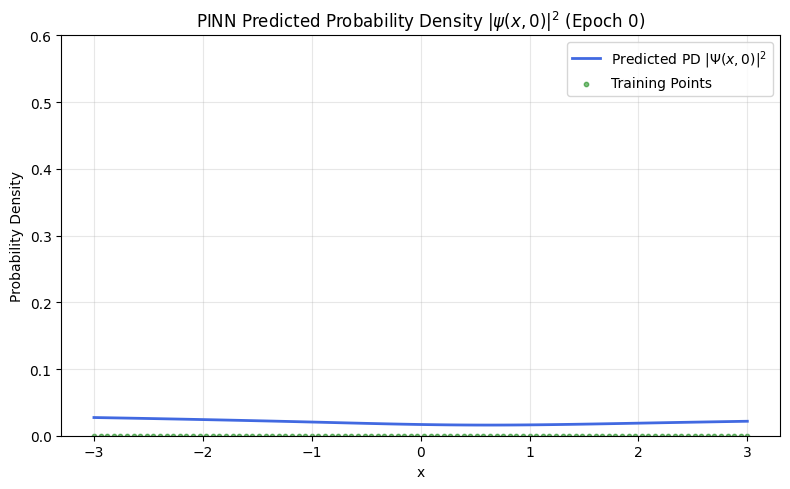

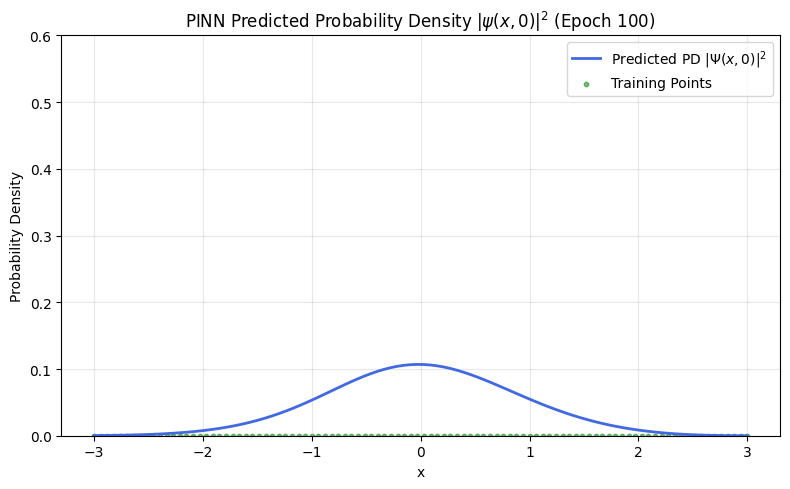

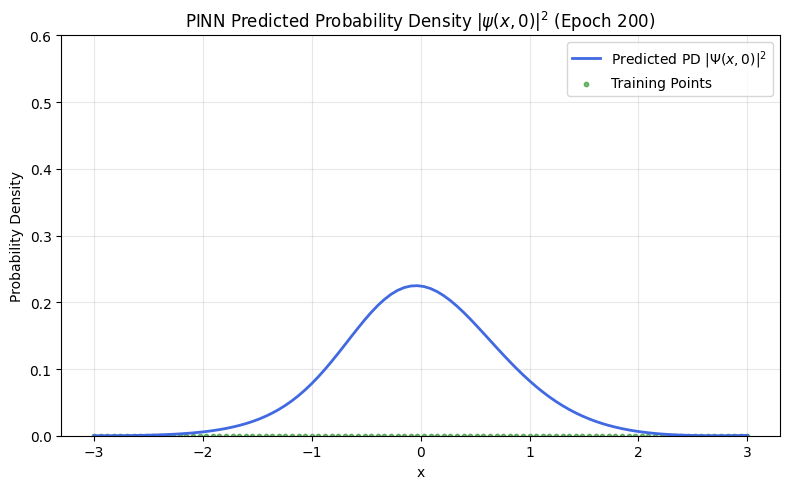

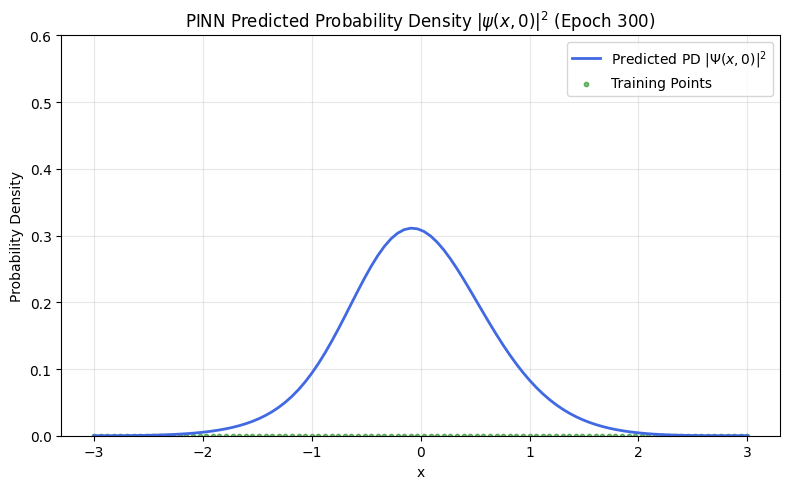

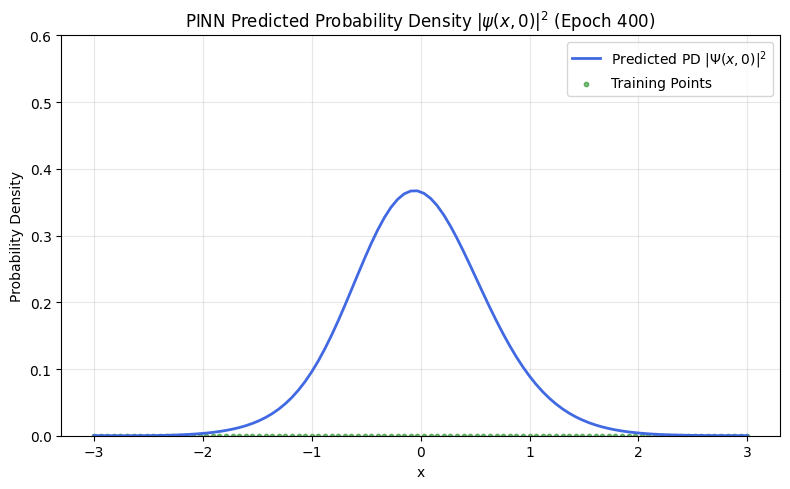

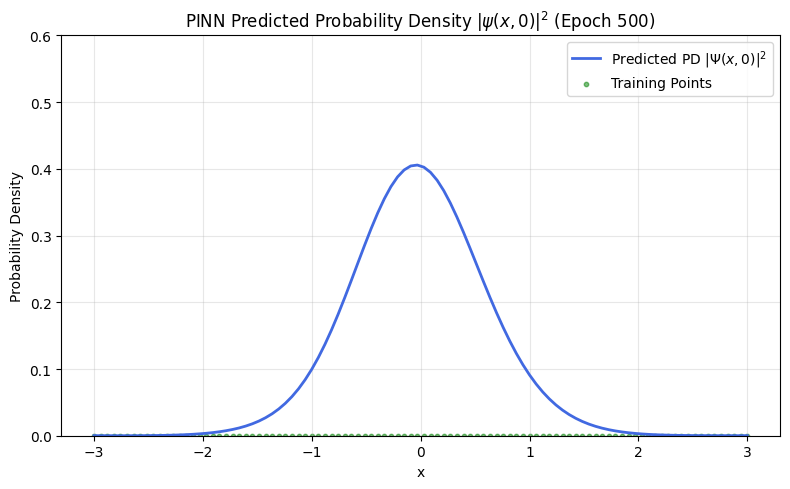

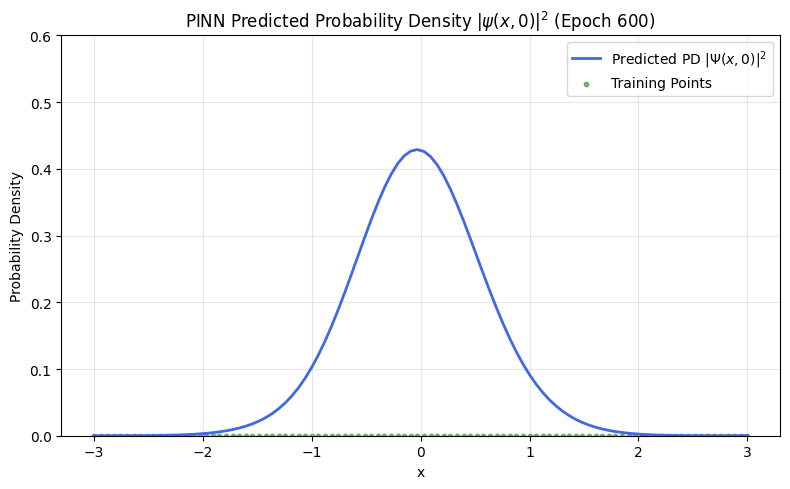

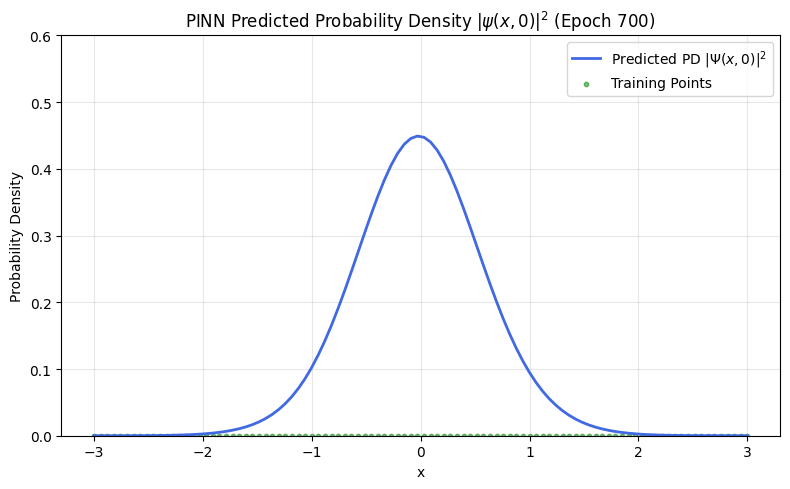

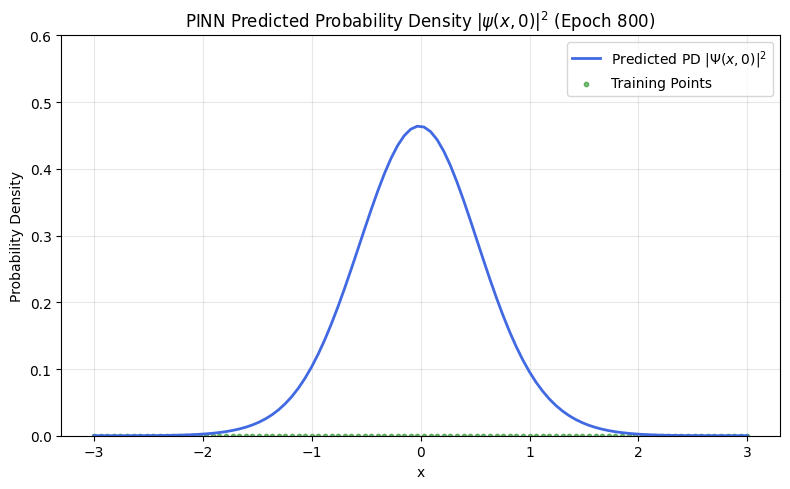

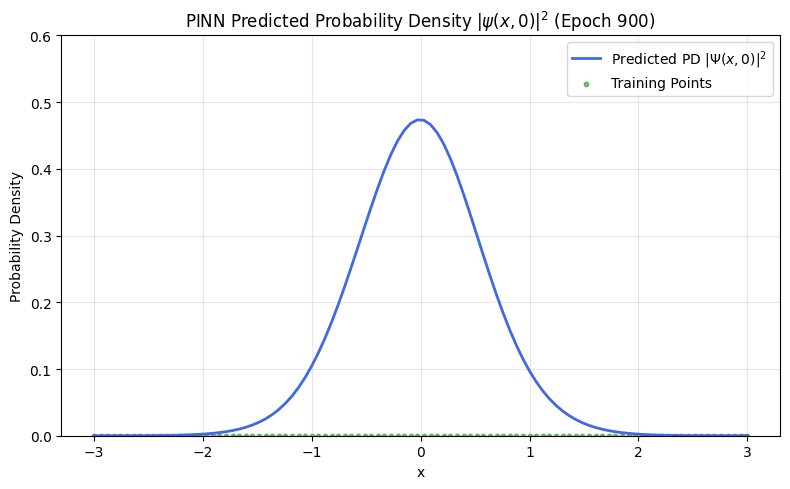

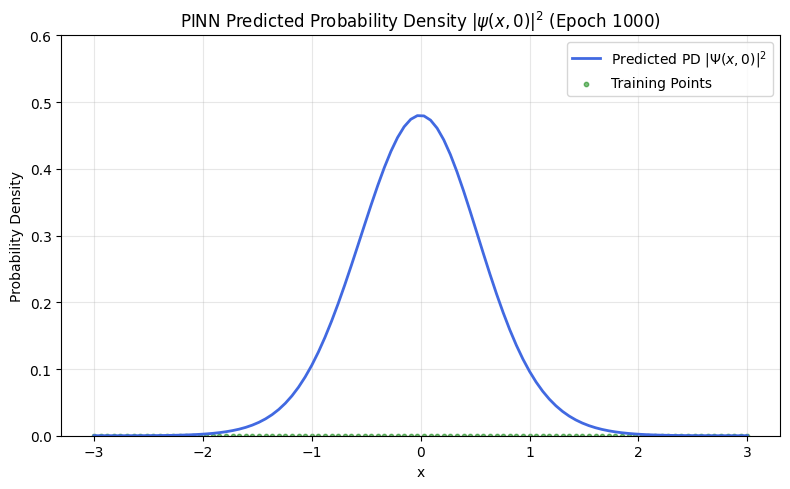

In [33]:
epochs = 1001  # Number of loops to train the neural network
files = []
loss_history = []
time_history = []

psi_model, phi_model, optimizer = initialise() #We want to restart training every time we run this block

# Training loop with progress bar
for N in tqdm(range(epochs), desc="Training PINN", unit=" epoch"):
    t0 = time.time()
    optimizer.zero_grad()
    L = loss(xt)
    L.backward()
    optimizer.step()
    loss_history.append(round(L.item(),6))
    time_history.append(time.time() - t0)
    # Snapshot interval
    if (N % 100) == 0:
        tqdm.write(f"Epoch {N}: Loss = {L.item():.6f}")
        
        # --- Compute current ψ ---
        psi_re, psi_im = psi_model(xt)
        psi = (psi_re + 1j * psi_im).detach().numpy().reshape(X.shape)
        PD = np.abs(psi) ** 2
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(X[:, 0].detach().numpy(), PD[:, 0],
                color='royalblue', lw=2, label=r'Predicted PD $|\Psi(x,0)|^2$')
        ax.scatter(x_train, [0]*len(x_train),
                   s=10, color='green', alpha=0.5,
                   label="Training Points")
        ax.set_xlabel("x")
        ax.set_ylabel("Probability Density")
        ax.set_ylim(0,0.6)
        ax.set_title(fr"PINN Predicted Probability Density $|\psi(x,0)|^2$ (Epoch {N})")
        ax.legend(loc = "upper right")
        ax.grid(alpha=0.3)
        fig.tight_layout()

        # --- Save frame ---
        filename = f"Plots/frame_{N:04d}.png"
        fig.savefig(filename, dpi=150)
        files.append(filename)

# ---------- Save GIF ----------
save_gif_PIL("training_evolution.gif", files, fps=5)
print(f"Simulation Completed with loss of {L.item():.6f}")

Here's the animation:
[Training Evolutions: PD wrt x in increasing Epochs](training_evolution.gif)

### Evaluating Loss
Here we plot out the loss with respect to epoch

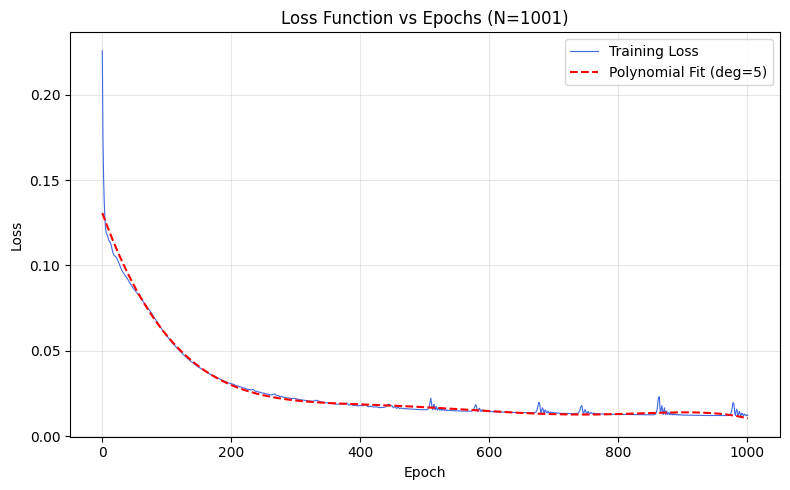

array([-1.93961452e-15,  5.87810627e-12, -6.82073300e-09,  3.79541099e-06,
       -1.03315542e-03,  1.30662750e-01])

In [38]:
# Convert to numpy
epochs_array = np.linspace(0, epochs, len(loss_history))
loss_array = np.array(loss_history)

# Polynomial fit (degree can be adjusted)
degree = 5
coeffs = np.polyfit(epochs_array, loss_array, degree)
poly_fit = np.poly1d(coeffs)

# Evaluate the fitted curve
smooth_epochs = np.linspace(0, epochs, 500)
smooth_loss = poly_fit(smooth_epochs)

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs_array, loss_array, lw=0.8, color='royalblue', label="Training Loss")
plt.plot(smooth_epochs, smooth_loss, 'r--', lw=1.5, label=f"Polynomial Fit (deg={degree})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Function vs Epochs (N={epochs})")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
coeffs

# Symbolic Regressions
Now that we have a solved wavefunction $\psi(x,t)$ we want to symbolically guess its functional form via a symbolic regression package such as `AI Feynman` or `PySR`

### Extracting the Dataset

In [39]:
entries = np.column_stack([
    xt[:, 0].detach().numpy(),  # x
    xt[:, 1].detach().numpy(),  # t
    psi_re.detach().numpy().flatten(),  # Re(psi)
    psi_im.detach().numpy().flatten(),  # Im(psi)
    PD.flatten()                        # |psi|^2
])
np.savetxt("psi_xt.dat", entries,
           header="x   t   Re(psi)   Im(psi)   |psi|^2",
           fmt="%.6e")

# To view the data, we can use the following function
def view_data(boolean):
    if boolean == True:
        with open("psi_xt.dat", "r") as f:
            print(f.read())
    return
# Usage: view_data(Boolean = True)

### PySR
Using `PySr`, we can try to get an analytical/symbolic solution. (The code will likely take a while to run!)

In [ ]:
import warnings
from tqdm import tqdm
import numpy as np
from pysr import PySRRegressor

warnings.filterwarnings("ignore")  # Suppress all runtime and future warnings

def symbolic_fit(X, y, target_name):
    model = PySRRegressor(
        niterations=100,
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log"],
        elementwise_loss="(x, y) -> (x - y)^2", 
        populations=10,
        maxsize=30,
        progress=True,  # shows progress bar
        verbosity=0,    # 1 gives short updates without flooding
    )
    print(f"Fitting {target_name} ...")
    model.fit(X, y)
    print(f"\nBest formula for {target_name}:")
    print(model.get_best())
    return model


# --- Example usage ---
data = np.loadtxt("psi_xt.dat", skiprows=1)
x, t, psi_re, psi_im, psi_abs2 = data.T
X = np.column_stack([x, t])

model_re = symbolic_fit(X, psi_re, "Re(ψ)")
model_im = symbolic_fit(X, psi_im, "Im(ψ)")
model_abs2 = symbolic_fit(X, psi_abs2, "|ψ|²")

In [ ]:
# Extract the equation only - Note: x0 and x1 is default variables which we will replace with x and t from our function
best_re = str(model_re.get_best()["sympy_format"]).replace("x0", "x").replace("x1", "t")
best_im = str(model_im.get_best()["sympy_format"]).replace("x0", "x").replace("x1", "t")
best_PD = str(model_abs2.get_best()["sympy_format"]).replace("x0", "x").replace("x1", "t")

# Combine symbolic form
psi_expr = f"ψ(x, t) = ({best_re}) + i*({best_im})"

# Print and export
print("Combined complex ψ(x, t):")
print(psi_expr)

print("Probability Density:")
print(best_PD)
